In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

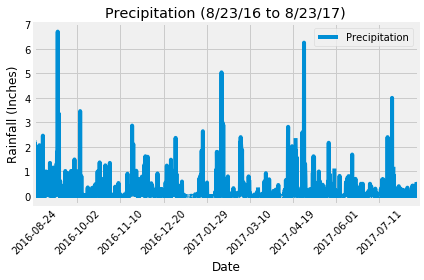

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database

endDate = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

lastYear = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

rainfall = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > lastYear).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

rainfall_df = pd.DataFrame(rainfall)


# Sort the dataframe by date

rainfall_df.set_index('date').head()

# Use Pandas Plotting with Matplotlib to plot the data

rainfall_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rainfall (Inches)")
plt.title("Precipitation (8/23/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rainfall_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [28]:
# Design a query to show how many stations are available in this dataset?
totalStations = session.query(Station).count()
print(f"Total Stations: {totalStations}")

Total Stations: 9


In [41]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# supplemental tutor taught me how to format for cleaner visualization for show list
stationCount = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())

# most active station
activeID = stationCount[0][0]

for result in stationCount:
    print(f"Station: {result[0]}\tCount: {result[1]}")
    
print("The most active station was",activeID,"with", stationCount[0][1],"total observations.")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511
The most active station was USC00519281 with 2772 total observations.


In [52]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowTemp = (session.query(Measurement.tobs).filter(Measurement.station == activeID).order_by(Measurement.tobs.asc()).first())

lowTemp = lowTemp[0]

highTemp = (session.query(Measurement.tobs).filter(Measurement.station == activeID).order_by(Measurement.tobs.desc()).first())

highTemp = highTemp[0]

avgTemp = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station == activeID))
avgTemp = '{0:.4}'.format(avgTemp[0][0])

print(lowTemp, highTemp, avgTemp)

54.0 85.0 71.66


In [50]:
# tutor taught me simple and cleaner version of the above
summary = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == activeID).all()
print(f"Lowest Temperature: {summary[0][0]}")
print(f"Highest Temperature: {summary[0][1]}")
print(f"Average Temperature: {round(summary[0][2], 2)}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


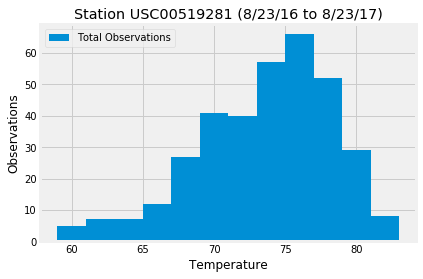

In [54]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

obsData = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > lastYear)
                   .filter(Measurement.station == activeID)
                   .order_by(Measurement.date)
                   .all())

obsData_df = pd.DataFrame(obsData)
plt.hist(obsData_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Observations")
plt.title("Station USC00519281 (8/23/16 to 8/23/17)")
plt.legend(["Total Observations"])
plt.show()

In [55]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [57]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

tripDates = '2019-06-06 to 2019-06-13'
tripStart = '2017-06-06'
tripEnd = '2017-06-13'

tripTemps = calc_temps(tripStart, tripEnd)

tripTemps


[(72.0, 77.1923076923077, 83.0)]

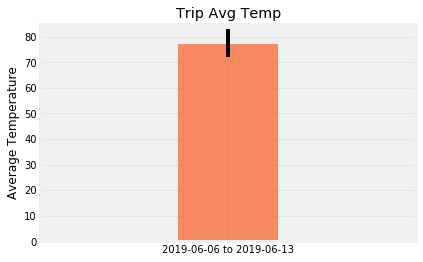

In [73]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

minTripTemp = tripTemps[0][0]
avgTripTemp = tripTemps[0][1]
maxTripTemp = tripTemps[0][2]

minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp

errorBars = np.array([[minError], [maxError]])

plt.bar(tripDates, avgTripTemp, yerr=errorBars, color = 'orangered', alpha = .6)
plt.ylim(0, 85)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Average Temperature')
plt.grid(alpha=.3)


In [75]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#query for precipitation per station on trip dates

sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRainfall = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= tripStart)
                   .filter(Measurement.date <= tripEnd)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

#convert object to data frame
stationRain_df = pd.DataFrame(np.array(stationRainfall))
#rename columns
stationRain_df = stationRain_df.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRain_df


,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",2.17,21.3331,-157.803,152.4
1,USC00519281,"WAIHEE 837.5, HI US",1.86,21.4517,-157.849,32.9
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.13,21.5213,-157.837,7
3,USC00513117,"KANEOHE 838.1, HI US",1.04,21.4234,-157.802,14.6
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.55,21.3356,-157.711,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.14,21.2716,-157.817,3
6,USC00517948,"PEARL CITY, HI US",None,21.3934,-157.975,11.9
